In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def tokenize_function(examples,tokenizer):
    result = tokenizer(examples["texte"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [4]:
def group_texts(examples,chunk_size):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [5]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
#datasest
data_files = {"train": "swerick_data_train.pkl", "test": "swerick_data_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 104
    })
    test: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 26
    })
})


In [8]:
tokenized_datasets = swerick_dataset.map(
      lambda examples: tokenize_function(examples, tokenizer), batched=True, remove_columns=["texte", "protocole",'__index_level_0__']
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 104
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 26
    })
})

In [9]:
chunk_size = 128

In [10]:
lm_datasets = tokenized_datasets.map( lambda examples: group_texts(examples,chunk_size), batched=True) #dataset with chunk
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 57099
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 12421
    })
})

In [11]:

with open("lm_dataset.pkl","wb") as fichier:
    pickle.dump(lm_datasets,fichier)

In [11]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)#add the MASK term

In [12]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
    logging_steps=logging_steps,
    logging_dir='./logs', 
    num_train_epochs=num_epochs
)

892


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [14]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/195 [00:00<?, ?it/s]

>>> Perplexity: 5633.22


In [15]:
trainer.train()

  0%|          | 0/6484600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
file_path = "finetuning_hugging.pth"
model.save_pretrained("finetuning_trainer_total")
tokenizer.save_pretrained("finetuning_trainer_total")

('finetuning_trainer/tokenizer_config.json',
 'finetuning_trainer/special_tokens_map.json',
 'finetuning_trainer/vocab.txt',
 'finetuning_trainer/added_tokens.json',
 'finetuning_trainer/tokenizer.json')

<class 'list'>
201


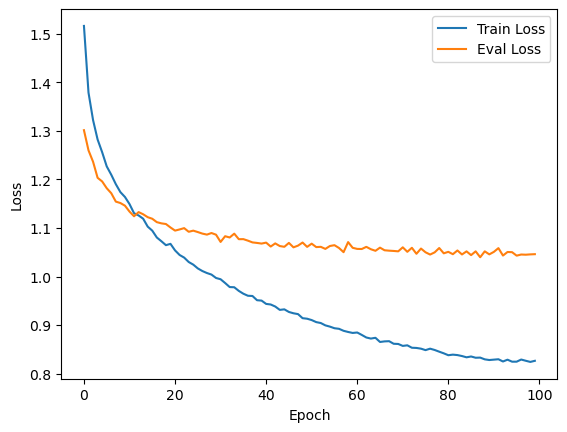

In [17]:
# Get the training and validation losses
print(type(trainer.state.log_history))
print(len(trainer.state.log_history))
train_losses=[]
test_losses=[]
for i in range(len(trainer.state.log_history)//2):
    train_losses.append(trainer.state.log_history[2*i]["loss"])
    test_losses.append(trainer.state.log_history[2*i+1]["eval_loss"])
#eval_losses = trainer.state.log_history["eval_loss"]

#print(train_losses)

# Plot the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import pickle

file_name = "losses_hugging.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': train_losses, 'losses_test': test_losses}, f)

In [ ]:
print(swerick_dataset)